#### Mounting Drive to access data (Uncomment if using Google colab)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive' , force_remount = True)
# intra_annotated_file = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/combined_annotated.csv"
# features_file = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/AE_features.csv"

#### Comment Out if using google colab

In [2]:
from imported_files.paths_n_vars import intra_annotated_file, features_file, ae_features_file, all_features_file, intra_annotated_file

#### Import TensorFlow and other libraries


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%pip install tensorflow --quiet
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
import functools

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

Note: you may need to restart the kernel to use updated packages.



Parameters

In [4]:
rand_state = 54
test_fraction = 0.1

latent_dim = 100
activation_func = 'ReLU'
activation_func_dec_out = 'ReLU'
optimizer = 'adam'
num_epochs = 300
batch_size = 32

save_model = True

User defined functions

In [5]:
def plot_signal(x ,y , x_label = "" , y_label = "" , title = ""):
    plt.grid(True)
    plt.plot(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

def timeit(function):
    @functools.wraps(function)
    def wrapper_timeit(*arg , **kwargs):
        
        start = time.perf_counter()
        function_output = function(*arg , **kwargs)
        end = time.perf_counter()
        print(f"{function.__name__} took : {end - start : 0.8f} seconds")
        
        return function_output
    
    return wrapper_timeit

# scale data
@timeit
def MyMinMaxScaler(dataframe:pd.DataFrame):
    return (dataframe - dataframe.min())/(dataframe.max() - dataframe.min())

#### Load the dataset

In [6]:
# # previous
# annotated_data = pd.read_csv(intra_annotated_file)

# re annotation
annotated_data = pd.read_csv('5.Ten_sec_annotated_data/patient_0_1_10.csv')


labels = annotated_data.iloc[0] # this will exract the annotation 2nd row
raw_segments = (annotated_data.iloc[1 : , ])

print(f"segments : labels \n{labels}")
print(f"raw_data = \n{raw_segments}")

assert not np.any(np.isnan(raw_segments)), "RAW DATA HAS NAN VALUES"

segments : labels 
Segment 3       0.0
Segment 6       0.0
Segment 7       0.0
Segment 8       0.0
Segment 9       0.0
               ... 
Segment 90.2    1.0
Segment 94.2    1.0
Segment 95.2    1.0
Segment 98.2    1.0
Segment 99.2    1.0
Name: 0, Length: 297, dtype: float64
raw_data = 
      Segment 3  Segment 6  Segment 7  Segment 8  Segment 9  Segment 10  \
1     -0.334136  -0.568938  -0.580043   0.560019  -0.817063    1.145565   
2     -0.340625  -0.584320  -0.500901   0.521373  -0.782862    1.117623   
3     -0.347306  -0.598611  -0.414744   0.482287  -0.740773    1.085596   
4     -0.354306  -0.611861  -0.322411   0.443223  -0.690712    1.050002   
5     -0.361761  -0.624151  -0.224900   0.404625  -0.632757    1.011349   
...         ...        ...        ...        ...        ...         ...   
1246  -0.388091   0.920667  -0.185927   0.832902   0.762606   -0.175110   
1247  -0.414397   0.966449  -0.212225   0.888338   0.716094   -0.201215   
1248  -0.442202   1.003270  -0.238832

MyMinMaxScaler took :  0.01624400 seconds
Scaled data shape = (1250, 297)


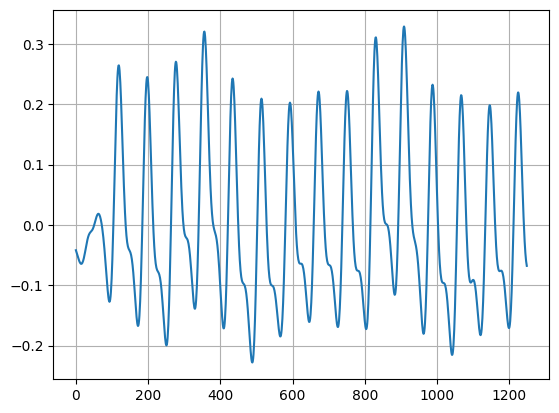

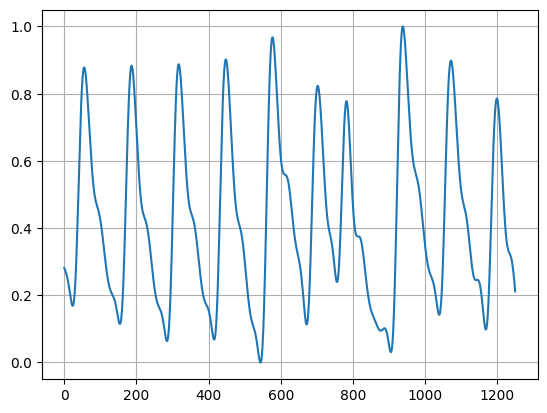

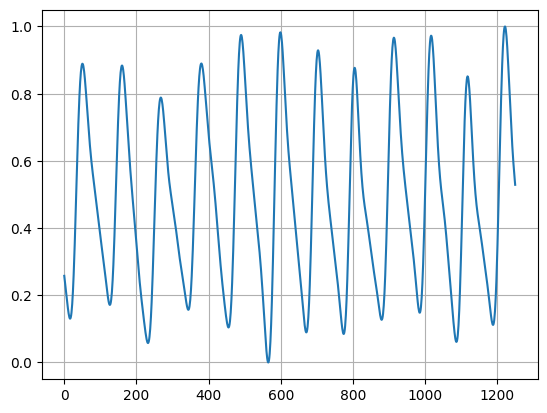

scaled_data = 
[[0.28133377 0.21318436 0.22694047 ... 0.26742846 0.5961739  0.2671155 ]
 [0.27862819 0.20665865 0.26097434 ... 0.27536693 0.60917184 0.27836334]
 [0.2758427  0.20059549 0.29802514 ... 0.28584483 0.623434   0.29013476]
 ...
 [0.23627816 0.88018186 0.37367407 ... 0.92164394 0.70238646 0.48500652]
 [0.22420351 0.89204079 0.36217995 ... 0.90682293 0.70423623 0.48016153]
 [0.21180265 0.90023191 0.35070305 ... 0.88891175 0.70553047 0.47514888]]


In [7]:
# %%timeit

scaled_data = MyMinMaxScaler(raw_segments).values
print(f"Scaled data shape = {scaled_data.shape}")

# # previous
# plot_signal(range(len(raw_segments["0_1"])) , raw_segments["0_1"])

# reannotation
plot_signal(range(len(raw_segments["Segment 1"])) , raw_segments["Segment 1"])


plot_signal(range(len(scaled_data[ : , 0])) , scaled_data[ : , 0])

# split the dataset using test_train_split() function
x_train, x_test, y_train, y_test = train_test_split(scaled_data.T , labels.values, test_size = test_fraction, random_state = rand_state, stratify = labels.values)

plot_signal(range(len(x_train[0])) , x_train[0])

print(f"scaled_data = \n{scaled_data}")

assert not np.any(np.isnan(scaled_data)) , "nan values in scaled Data"

**Basic autoencoder**

#### Simplified Autoencoder

In [8]:
class Autoencoder(Model):
    def __init__(self, latent_dim, num_samples, activation_function , activation_function_decoder_out):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
              layers.Flatten(),
              layers.Dense(800, activation=activation_function , name = "Encoder1" , kernel_initializer = 'RandomNormal'),
              layers.Dense(400, activation=activation_function , name = "Encoder2", kernel_initializer = 'RandomNormal'),
              layers.Dense(300, activation=activation_function , name = "Encoder3", kernel_initializer = 'RandomNormal'),
            ])
        self.decoder = tf.keras.Sequential([
              layers.Dense(400, activation=activation_function , name = "Decoder1", kernel_initializer = 'RandomNormal'),
              layers.Dense(800, activation=activation_function , name = "Decoder2", kernel_initializer = 'RandomNormal'),
              layers.Dense(1250, activation=activation_function_decoder_out , name = "Decoder3", kernel_initializer = 'RandomNormal'),
            ])
        
        # # single layer Autoencoder
        # self.encoder = tf.keras.Sequential([
        #       layers.Flatten(),
        #       layers.Dense(latent_dim, activation=activation_function , name = "Encoder"),
        #     ])
        # self.decoder = tf.keras.Sequential([
        #       layers.Dense(num_samples, activation=activation_function_decoder_out , name = "Decoder"),
        #     ])
        
        # self.encoder = tf.keras.Sequential([
        #       layers.Flatten(),
        #       layers.Dense(int(num_samples/2) , activation = activation_func , name = "Encoder_in"), 
        #       layers.Dense(latent_dim, activation='tanh' , name = "Coded_representation"),
        #     ])
        # self.decoder = tf.keras.Sequential([
        #       layers.Dense(int(num_samples/2) , activation = activation_func , name = "Decoder_in"),
        #       layers.Dense(num_samples, activation=activation_function , name = "Decoded_output"),
        #     ])
        
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

num_samples = x_test.shape[1]

autoencoder = Autoencoder(latent_dim, num_samples, activation_func, activation_func_dec_out)

autoencoder.compile(optimizer = optimizer, loss = losses.MeanSquaredError(), metrics = ['mae'])

tf.debugging.set_log_device_placement(True)

# configure early stopping
es = EarlyStopping(monitor='loss', patience=5)
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

with tf.device('/device:GPU:0'):
  autoencoder.fit(x_train, x_train,
                epochs = num_epochs,
                shuffle = True,
                batch_size = batch_size,
                validation_data = (x_test, x_test),
                callbacks = [es,  tbCallBack])



Epoch 1/300


9/9 [==============================] - 6s 150ms/step - loss: 0.2201 - mae: 0.3698 - val_loss: 0.1167 - val_mae: 0.2691
Epoch 2/300
9/9 [==============================] - 1s 75ms/step - loss: 0.1003 - mae: 0.2469 - val_loss: 0.0875 - val_mae: 0.2265
Epoch 3/300
9/9 [==============================] - 1s 75ms/step - loss: 0.0853 - mae: 0.2240 - val_loss: 0.0810 - val_mae: 0.2159
Epoch 4/300
9/9 [==============================] - 1s 70ms/step - loss: 0.0796 - mae: 0.2146 - val_loss: 0.0760 - val_mae: 0.2080
Epoch 5/300
9/9 [==============================] - 1s 70ms/step - loss: 0.0741 - mae: 0.2057 - val_loss: 0.0709 - val_mae: 0.1997
Epoch 6/300
9/9 [==============================] - 1s 72ms/step - loss: 0.0692 - mae: 0.1973 - val_loss: 0.0667 - val_mae: 0.1950
Epoch 7/300
9/9 [==============================] - 1s 73ms/step - loss: 0.0632 - mae: 0.1873 - val_loss: 0.0606 - val_mae: 0.1827
Epoch 8/300
9/9 [==============================] - 1s 80ms/step - loss: 0.0570 - mae:

#### Testing the trained autoencoder

In [9]:
# import os
# encoder = Autoencoder()
# if os.path.exists("model.h5"):
#     encoder = tf.keras.models.load_model("model.h5")

# autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 Encoder1 (Dense)            (None, 800)               1000800   
                                                                 
 Encoder2 (Dense)            (None, 400)               320400    
                                                                 
 Encoder3 (Dense)            (None, 300)               120300    
                                                                 
Total params: 1441500 (5.50 MB)
Trainable params: 1441500 (5.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


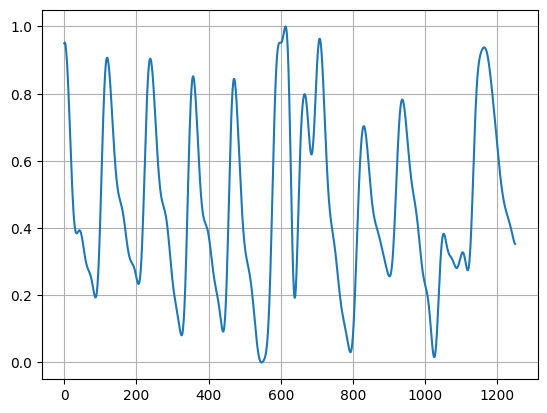

[0.94997734 0.95233814 0.95147374 ... 0.35680223 0.35439952 0.3528505 ]
tf.Tensor([[0.92080754 0.878714   0.         ... 0.37708464 0.3354381  0.3411958 ]], shape=(1, 1250), dtype=float32)


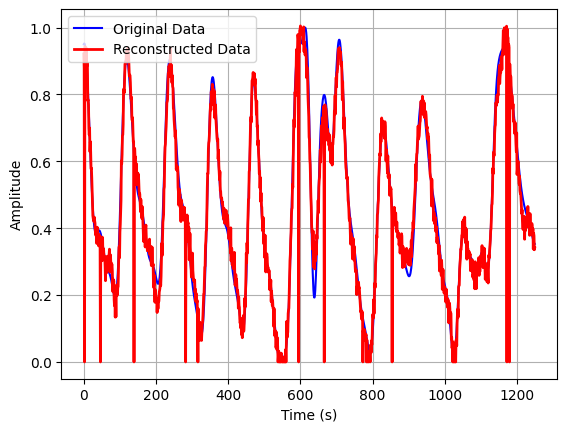

In [10]:
autoencoder.encoder.summary()
# plot_model(autoencoder, 'model.png', show_shapes=True)
segment = x_train[85]
# segment = segment  # Reshape the segment to match the autoencoder input shape
plot_signal(range(len(segment)),segment)
print(segment)
t = range(len(segment) )
# print(t)
reconstructed_seg = autoencoder(tf.reshape(segment , [1,1250]))
print(reconstructed_seg)
plt.figure()
plt.plot(t, segment, 'b-', label='Original Data')
plt.plot(t, np.array(reconstructed_seg).reshape(1250,1), 'r-', linewidth = 2, label='Reconstructed Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#### Extract and save features

In [11]:
from pprint import pprint
def encode_data(array):
    nl_features = autoencoder.encoder(tf.reshape(array ,  [array.shape[1],1250])) # non linear features
    header = [f"AE_{i}" for i in range(len(nl_features[0]))] 
    return pd.DataFrame(data = nl_features , columns = header)
    # return pd.DataFrame( { f"AE_{i}" : nl_features[i] for i in range(len(nl_features[0])) })
# print(type(scaled_data))
print(scaled_data.shape)
# print(len(scaled_data))
AE_features = encode_data(scaled_data)
print(AE_features)
AE_features.to_csv(ae_features_file , index=False )

(1250, 297)
     AE_0      AE_1      AE_2      AE_3  AE_4  AE_5  AE_6  AE_7  AE_8  AE_9  \
0     0.0  0.064676  0.000000  0.731023   0.0   0.0   0.0   0.0   0.0   0.0   
1     0.0  0.109191  0.439547  0.587211   0.0   0.0   0.0   0.0   0.0   0.0   
2     0.0  0.287510  0.341388  0.534680   0.0   0.0   0.0   0.0   0.0   0.0   
3     0.0  0.179949  0.409516  0.810676   0.0   0.0   0.0   0.0   0.0   0.0   
4     0.0  0.583237  0.495639  0.812627   0.0   0.0   0.0   0.0   0.0   0.0   
..    ...       ...       ...       ...   ...   ...   ...   ...   ...   ...   
292   0.0  0.048828  0.334346  0.825612   0.0   0.0   0.0   0.0   0.0   0.0   
293   0.0  0.294273  0.470315  0.759392   0.0   0.0   0.0   0.0   0.0   0.0   
294   0.0  0.469742  0.245392  0.893851   0.0   0.0   0.0   0.0   0.0   0.0   
295   0.0  0.405797  0.392141  0.789498   0.0   0.0   0.0   0.0   0.0   0.0   
296   0.0  0.408740  0.312756  0.632222   0.0   0.0   0.0   0.0   0.0   0.0   

     ...  AE_290    AE_291  AE_292    A

##### Concat with other features

In [12]:
# features_df = pd.read_csv(features_file , header = None , skiprows=1)
# AE_features = pd.read_csv(ae_features_file , header = None)
# all_features_df = pd.concat([features_df , AE_features] , axis = 1)
# print(all_features_df)
# all_features_df.to_csv(all_features_file , index=False)

#### Save the model

In [13]:
# save model to file
# if save_model:
autoencoder.encoder.save('model.keras')

#### Check accuracy with RF


~~~~~ RF:: WITH AE FEATURES ONLY ~~~~~
Train instances : {1.0: 39, 0.0: 70, 2.0: 39}
Test instances : {0.0: 71, 1.0: 40, 2.0: 38}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s


[0.35294118 0.41176471 0.23529412 0.35294118 0.375      0.3125
 0.5625     0.5        0.3125     0.29411765 0.29411765 0.41176471
 0.47058824 0.375      0.5        0.1875     0.6875     0.4375
 0.41176471 0.29411765 0.47058824 0.35294118 0.375      0.5
 0.5        0.4375     0.4375     0.29411765 0.41176471 0.35294118
 0.52941176 0.4375     0.4375     0.5625     0.5        0.1875
 0.47058824 0.47058824 0.41176471 0.52941176 0.4375     0.375
 0.5        0.5625     0.5625     0.41176471 0.35294118 0.35294118
 0.29411765 0.4375     0.25       0.625      0.5        0.4375
 0.29411765 0.29411765 0.35294118 0.35294118 0.5        0.375
 0.625      0.5625     0.4375     0.58823529 0.52941176 0.35294118
 0.52941176 0.4375     0.3125     0.5        0.3125     0.3125
 0.41176471 0.35294118 0.35294118 0.41176471 0.625      0.5
 0.4375     0.5625     0.5       ]
Accuracy : mean = 0.4243373275236021 :: std = 0.10411918082955686


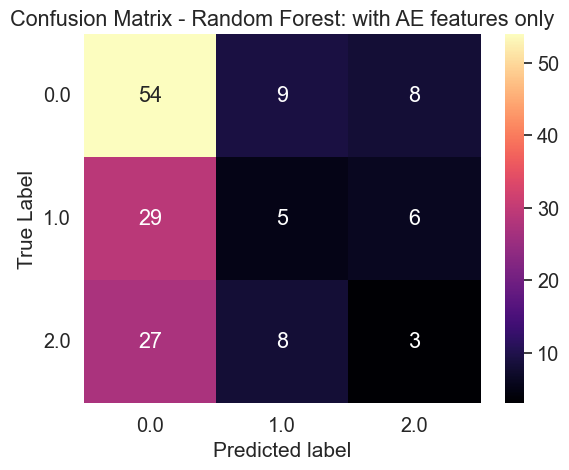

Confu mtrx = 
[[54  9  8]
 [29  5  6]
 [27  8  3]]

Classification Report:

              precision    recall  f1-score   support

         0.0       0.49      0.76      0.60        71
         1.0       0.23      0.12      0.16        40
         2.0       0.18      0.08      0.11        38

    accuracy                           0.42       149
   macro avg       0.30      0.32      0.29       149
weighted avg       0.34      0.42      0.36       149


Avg score on test dataset = 0.4161073825503356
RandomForestClassifier(n_estimators=15, random_state=54, verbose=1)


In [15]:
from imported_files.paths_n_vars import features_file, intra_annotated_file, all_features_file, ae_features_file
# import features_scaler as fScaler

rand_state = 54
test_fraction = 0.5
num_trees = 15
split_criteria = "gini"

# k of k flod cross validation
k = 9 # change if you want to experiment

# class list
# class_list = ["0" , "1"] # good segn = 0 , corrupted signal = 1

# ~~~~~~~LIBRARIES~~~~~~~
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# for cross validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# for creating confusion matrix
from sklearn import metrics

# to plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns # seaborn for additional functionality such as heat map

# additionals
from sklearn.metrics import classification_report

# to calculate number of instances of 0 and 1
from collections import Counter
# ~~~~~~~~~~~~END LIBRARIES~~~~~~~~~~~~~~~~~~~~~

def create_train_classifier(x_train_data , y_train_data):
    return RandomForestClassifier(n_estimators = num_trees , random_state = rand_state \
                                  , criterion = split_criteria, verbose = 1).fit(x_train_data , y_train_data)
    
def k_fold_s_crossval(x_train_data , y_train_data , k_value , classifier):
    rskf = RepeatedStratifiedKFold(n_splits = k_value , n_repeats = k_value , random_state = rand_state)
    result = cross_val_score(classifier , x_train_data , y_train_data , cv = rskf , verbose = 1)
    print("Cross validation Accuracy : mean = {} :: std = {}".format(result.mean() , result.std()))


def test_n_results(x_test_data , y_test_data , classifier , description:str = ""):

    # Now TESTING the model and showing the results:
    # confusion matrix 
    test_pred_decision_tree = classifier.predict(x_test_data)
    confusion_matrix = metrics.confusion_matrix(y_test_data , test_pred_decision_tree)
    class_list = np.unique(y_test_data)
    ax = plt.axes()
    sns.set_theme(font_scale=1.3)
    sns.heatmap(confusion_matrix , annot = True , fmt = "g" , ax = ax , cmap = "magma")
    ax.set_title('Confusion Matrix - Random Forest: ' + description)
    ax.set_xlabel("Predicted label" , fontsize = 15)
    ax.set_xticklabels(class_list)
    ax.set_ylabel("True Label", fontsize = 15)
    ax.set_yticklabels(class_list, rotation = 0)
    plt.show()

    # # roc curve plot
    # ax = plt.gca()
    # rfc_disp = metrics.RocCurveDisplay.from_estimator(classifier, x_test_data, y_test_data, ax=ax, alpha=0.8)
    # plt.show()

    # classification report
    print(f"Confu mtrx = \n{confusion_matrix}")
    print("\nClassification Report:\n")
    print(classification_report(y_test_data, test_pred_decision_tree))
    print("\nAvg score on test dataset = {}".format(classifier.score(x_test_data , y_test_data)))
    print(classifier)

def rf_model( local_features_file, annotated_file , description : str = ""):
    # get the dataset from the files
    features = pd.read_csv(local_features_file)
    labels = pd.read_csv(annotated_file).iloc[0] # this will exract the annotation 2nd row

    if local_features_file == annotated_file:
        features.drop(index=0, inplace=True)
        features = features.T
    if 'annotation' in features.columns :
        features.drop(['annotation'] , axis = 'columns' , inplace = True)

    assert not np.any(np.isnan(features)) , "ERROR::FEATURES DATAFRAME HAS NAN VALUES"
    # split the dataset using test_train_split() function
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = test_fraction, random_state = rand_state, stratify = labels)

    num_instances_train = dict(Counter(y_train))
    num_instances_test = dict(Counter(y_test))
    print(f"Train instances : {num_instances_train}")
    print(f"Test instances : {num_instances_test}")

    clf = create_train_classifier(x_train , y_train)
    k_fold_s_crossval(x_train , y_train , k , clf)
    test_n_results(x_test , y_test , clf , description)
    
print("\n~~~~~ RF:: WITH AE FEATURES ONLY ~~~~~")
rf_model( ae_features_file, '5.Ten_sec_annotated_data/patient_0_1_10.csv' , description = "with AE features only")